**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


<p align="center">
<img src="media/rag_overview.png" alt="LLM" width="800"/> <br>
Image from HuggingFace's "<i><a href="https://huggingface.co/learn/cookbook/rag_evaluation">RAG Evaluation</a></i>" by <a href="https://huggingface.co/m-ric">Aymeric Roucher</a>.<br> Copyright © 2025. All rights reserved.
</p>

***
Sources: <br>
- [RAG Evaluation (HuggingFace)](https://huggingface.co/learn/cookbook/rag_evaluation)
- [RAG: Retrieval-Augmented Generation (LangChain)](https://python.langchain.com/docs/concepts/rag/)
- [RAG Retrieval](https://python.langchain.com/docs/concepts/retrieval/)
- [Embedding Models (LangChain)](https://python.langchain.com/docs/concepts/embedding_models/)
- [Building a Semantic Search Engine for Internal Documentation: A Comprehensive Guide](https://blog.devgenius.io/building-a-semantic-search-engine-for-internal-documentation-a-comprehensive-guide-270efa9a30a0)
- [Build a Retrieval Augmented Generation (RAG) App: Part 1](https://python.langchain.com/docs/tutorials/rag/)


## Retrieval Augmented Generation (RAG)

Retrieval Augmented Generation (RAG) is a powerful technique that enhances [language models](/docs/concepts/chat_models/) by combining them with external knowledge bases. RAG is a technique used to address [a key limitation of models](https://arxiv.org/abs/2401.11817): Generative language models rely on fixed training datasets, which can lead to outdated or incomplete information - and they will likely not know the answer to domain-specific questions like confidential company information. When an LLM is presented with a query that it doesn't know the answer to, the best case scenario is that it will respond with "I don't know." However, as generative models lack self-reflection and are trained to, well, generate, in many cases, the model will generate a response that is incorrect, irrelevant or directly misleading, a phenomenon known as *hallucinations*.

### Understanding hallucinations
Research (e.g., "*[Hallucination is inevitable: An innate limitation of large language models](https://arxiv.org/abs/2401.11817)"* (2024) by Xu, Z., Jain, S., & Kankanhalli, M.) shows that hallucinatory behavior is a fundamental limitation of LLMs. As autoregressive models, they generate text sequentially with no mechanism to verify factual accuracy against reality. Their knowledge is fixed in parameters during training and lacks external grounding during generation. Mathematical proofs show that even theoretically perfect LLMs cannot learn all computable functions, making some degree of hallucination inevitable. This limitation applies not just in theoretical frameworks but extends to all real-world LLM applications as well. One dire example is [how a lawyer used ChatGPT in court and cited fake cases, leading to a judge considering sanctions.](https://www.forbes.com/sites/mollybohannon/2023/06/08/lawyer-used-chatgpt-in-court-and-cited-fake-cases-a-judge-is-considering-sanctions/?sh=3fd97317c7f3&ref=alhena.ai). When forced to find an answer outside its training data, the model simply invents one. 

| Query                                | LLM Response                                             | Error                                                                 |
|--------------------------------------|----------------------------------------------------------|-----------------------------------------------------------------------|
| What is Ann Frank's favorite smartphone? | Ann Frank's favorite smartphone is the iPhone 12 Pro Max. | Anne Frank died in 1945, and the iPhone 12 Pro Max was released in the 2020s. |


Another interesting perspective is given by [Andrej Karpathy](https://karpathy.ai/), Eureka Labs and former Director of AI at Tesla, who [tweeted](https://x.com/karpathy/status/1733299213503787018?lang=es):

> *"I always struggle a bit with I'm asked about the "hallucination problem" in LLMs. Because, in some sense, hallucination is all LLMs do. They are dream machines. We direct their dreams with prompts. The prompts start the dream, and based on the LLM's hazy recollection of its training documents, most of the time the result goes someplace useful. It's only when the dreams go into deemed factually incorrect territory that we label it a "hallucination". It looks like a bug, but it's just the LLM doing what it always does.*

> *At the other end of the extreme consider a search engine. It takes the prompt and just returns one of the most similar "training documents" it has in its database, verbatim. You could say that this search engine has a "creativity problem" - it will never respond with something new. An LLM is 100% dreaming and has the hallucination problem. A search engine is 0% dreaming and has the creativity problem. \[...\]"*

### Mitigating hallucinations
While various approaches to mitigate hallucinatory behavior continue to develop, the underlying constraints ensure that some degree of hallucination will persist in any LLM implementation. When faced with a hallucinating model, we would like to feed it with more information. The intuitive way to accomplish this is to fine-tune the model on a specific dataset. However, this approach is costly and time-consuming, and it may not be feasible for all applications. And what if we have information that changes frequently, like news, product prices, or stock market data? Fine-tuning is not a practical solution in these cases because the model would need to be retrained every time the data changes. Broadly speaking, there are three ways to mitigate hallucinations:
| Approach            | Pros                                                                 | Cons                                                                 |
|---------------------|----------------------------------------------------------------------|---------------------------------------------------------------------|
| **Fine-tuning**     | Reduces hallucinations by training on specific datasets, Can improve model performance in specific domains | Costly and time-consuming, Not feasible for frequently changing information |
| **Self-reflection** | Models can admit when they don't know the answer, Can reduce incorrect or misleading responses | Still in early stages of development, Might block hallucinations but doesn't expand the models knowledge. |
| **External grounding** | Provides models with external knowledge sources to ground responses, Can significantly reduce hallucinations | Requires access to up-to-date and relevant knowledge bases, May involve additional complexity in system design and maintenance |

### RAG as external grounding
The inherent limitation of hallucinary behaviour highlights why complementary approaches like RAG have become popular. With RAG, we can induce the model with external knowledge *at inference time* instead of training time, a very cost effective alternative to fine-tuning. By grounding LLM responses in external, verifiable knowledge sources, RAG provides a practical technique to reduce hallucinations and (hopefully) improve the reliability of AI-generated content.

### How does RAG work?
When given a query, before the LLM sees the input, RAG systems first search a knowledge base for information relevant to the query (using semantic similarity search via a [retriever](/docs/concepts/retrievers/)). The system then incorporates this retrieved information into the model's prompt. This means that the model can use the provided context to generate a response to the query. What we are really doing is *grounding* the model's response in the retrieved context, which helps to reduce hallucinations and improve the quality of the response.

More specifically, if we follow the image above, the RAG system works as follows:

| Phase               | Stage            | Steps                                                                 |
|---------------------|------------------|----------------------------------------------------------------------|
| **Pre-Production**  | Knowledge Base Preparation | 1. Start with a collection of documents/information sources <br> 2. Apply chunking methods to break documents into manageable pieces <br> 3. Embed documents using an embedding model <br> 4. Store embeddings in a vector database |
| **Production**      | Retriever Stage  | 1. Receive user query <br> 2. (Optionally reformulate the user query to improve retrieval) <br> 3. Embed the user query using the same embedding model <br> 4. Find closest documents to the embedded query in the vector database <br> (5. Possibility to use metadata in search process) |
| **Production**   | Reader Stage     | 1. Retrieve top k similar documents (Documents contain text content, vector embeddings, and metadata) <br> 2. Post-process and aggregate document contents into a context <br> (Can apply prompt compression techniques and/or reranking if needed) <br> 3. Build a prompt based on the user query and context (Consider prompt choice strategies) <br> 4. Pass the prompt to the LLM <br> 5. LLM generates a response from the query, system prompt and context <br> 6. (Optionally verify the generated response) <br> 7. Return the LLM answer to the user |

***

<br><br>

## Key concepts


<p align="center">
<img src="media/rag_concepts.png" alt="LLM" width="800"/> <br>
Image from <a href="https://www.langchain.com/">LangChain</a>'s "<i><a href=https://python.langchain.com/docs/concepts/rag/">Retrieval augmented generation (RAG)</a></i>".<br> Copyright © 2025. All rights reserved.
</p>

0. **Creating a knowledge base**: Collect and embed relevant documents.

1. **Retrieval system**: Retrieve relevant information from a knowledge base.

2. **Using external knowledge**: Pass retrieved information to a model.

***


### Creating a knowledge base

The first step in setting up a RAG system is to create a knowledge base. This involves collecting and *embedding* relevant documents that the model can use to ground its responses. Consider the table below as inspiration for the types of data sources you might use in different domains:

| Use Case                | Relevant Data Sources                                                                 |
|-------------------------|----------------------------------------------------------------------------------------|
| **Customer Support**    | FAQ documents, product manuals, support tickets, knowledge base articles               |
| **Healthcare**          | Medical journals, clinical trial data, patient records, drug information databases      |
| **Finance**             | Financial reports, stock market data, economic indicators, investment research reports |
| **E-commerce**          | Product catalogs, customer reviews, sales data, inventory records                       |
| **Education**           | Textbooks, lecture notes, research papers, online course materials                      |
| **Legal**               | Case law databases, legal statutes, contracts, legal opinions                           |
| **News**                | News articles, press releases, social media feeds, news agency reports                  |
| **Travel**              | Travel guides, hotel reviews, flight schedules, destination information                 |

<br>

> The quality of the knowledge base is crucial for the performance of the RAG system. The documents should be relevant, up-to-date, and diverse enough to cover a wide range of topics. This alone presents a whole set of challenges, such as data collection, cleaning, updating, and deduplication, which are beyond the scope of this guide.

> The knowledge base can contain not only text but also other types of content, such as images, audio, or video. In this case, the retrieval system should be able to handle multimodal data and provide the model with the relevant information. This, however, adds another layer of complexity to the system, and lies beyond the scope of this guide.

### Embedding documents

<p align="center">
<img src="media/semantic_space.png" alt="LLM" width="800"/> <br>
Image from <a href="https://www.langchain.com/">LangChain</a>'s "<i><a href=https://python.langchain.com/docs/concepts/embedding_models/">Embedding models</a></i>".<br> Copyright © 2025. All rights reserved.
</p>

Imagine being able to capture the essence of any text - a tweet, document, or book - in a single, compact representation. This is the power of embedding models, which lie at the heart of many retrieval systems. Embedding models transform human language into a format that machines can understand and compare with speed and accuracy. These models take text as input and produce a fixed-length array of numbers, a numerical fingerprint of the text's semantic meaning. Embeddings allow search system to find relevant documents not just based on keyword matches, but on semantic understanding.

Each embedding is essentially a set of coordinates, often in a high-dimensional space. In this space, the position of each point (embedding) reflects the meaning of its corresponding text. Just as similar words might be close to each other in a thesaurus, similar concepts end up close to each other in this embedding space. This allows for intuitive comparisons between different pieces of text. By reducing text to these numerical representations, we can use simple mathematical operations to quickly measure how alike two pieces of text are, regardless of their original length or structure. Some common similarity metrics include:

- Cosine Similarity: Measures the cosine of the angle between two vectors.
- Euclidean Distance: Measures the straight-line distance between two points.
- Dot Product: Measures the projection of one vector onto another.

**Remember how we used BERT embeddings in MA2?** BERT is just one example of an embedding (or an *encoder*) model. Embedding models are trained on large amounts of text data to learn the relationships between words, sentences, and documents. In contrast to generative models, which produce text, embedding models are discriminative models that map text to a fixed-size vector.

**In a RAG settings, the retrieval system uses these embeddings to find the most relevant documents to a given query.**

#### Steps to create a knowledge base

<p align="center">
<img src="media/indexing.png" alt="LLM" width="800"/> <br>
Image from <a href="https://www.langchain.com/">LangChain</a>'s "<i><a href=https://python.langchain.com/docs/tutorials/rag/">Build a Retrieval Augmented Generation (RAG) App: Part 1</a></i>".<br> Copyright © 2025. All rights reserved.
</p>

Essentially, we need to accomplish four things to create a knowledge base, as shown in the image above.

1. **Load**: First we need to load our data. This is done with Document Loaders.
2. **Split**: Text splitters break large documents into smaller chunks. This is useful (and often needed) both for indexing data and passing it into a model, as large chunks are harder to search over and won't fit in a model's finite context window.
3. **Embed**: We need to convert our text into embeddings. This is done using an `embedding model`.
4. **Store**: We need somewhere to store and index our splits, so that they can be searched over later. This is often done using a `VectorStore`.

#### Chunking strategies
What is the best way to split documents into chunks? There are several strategies, each with its own trade-offs:

| Strategy                | Description                                                                                                                                                                                                 | Pros                                                                 | Cons                                                                 |
|-------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------|---------------------------------------------------------------------|
| Fixed-size chunking     | Text splitting with a specific chunk size and optional chunk overlap. This approach is the most common and straightforward.                                                                                  | Simple to implement, Consistent chunk sizes                          | May split important context, Not context-aware                      |
| Recursive chunking      | Iterating default separators until one of them produces the preferred chunk size. Default separators include ["\n\n", "\n", " ", ""]. This chunking method uses hierarchical separators to keep paragraphs, followed by sentences and then words, together as much as possible. | Maintains logical structure, Flexible                                | Can be computationally expensive, May still split important context |
| Semantic chunking       | Splitting text in a way that groups sentences based on the semantic similarity of their embeddings. Embeddings of high semantic similarity are closer together than those of low semantic similarity. This results in context-aware chunks. | Context-aware, Preserves semantic meaning                            | Requires embedding computation, More complex to implement           |
| Document-based chunking | Splitting based on document structure. This splitter can utilize Markdown text, images, tables and even Python code classes and functions as ways of determining structure. In doing so, large documents can be chunked and processed by the LLM. | Preserves document structure, Versatile                              | May require custom logic for different document types               |
| Agentic chunking        | Leverages agentic AI by allowing the LLM to determine appropriate document splitting based on semantic meaning as well as content structure such as paragraph types, section headings, step-by-step instructions and more. This chunker is experimental and attempts to simulate human reasoning when processing long documents. | Highly context-aware, Simulates human reasoning                      | Experimental, May be inconsistent, Computationally expensive         |

The choice of the chunking strategy is an often overlooked but extremely important part of building a RAG system. The right strategy can significantly improve the quality of the generated responses, while the wrong strategy can lead to irrelevant or incorrect information being passed to the model. The best strategy depends on the nature of the documents in the knowledge base and the requirements of the application. Generally speaking, you will want to start off with something simple like fixed-size chunking and then experiment with more advanced strategies to see if they improve the performance of the system.


### Retrieval system

<p align="center">
<img src="media/semantic_search.png" alt="LLM" width="800"/> <br>
Image from <a href="https://blog.devgenius.io">Dev Genius</a>'s <i><a href=https://blog.devgenius.io/building-a-semantic-search-engine-for-internal-documentation-a-comprehensive-guide-270efa9a30a0">Building a Semantic Search Engine for Internal Documentation</a></i>" by <a href="https://www.linkedin.com/in/timothyurista/">Tim Urista</a><br> Copyright © 2024. All rights reserved.
</p>

Remember that RAG is an abbreviation for "*Retrieval*-Augmented Generation." A retrieval system is a key component of RAG that searches for relevant information in a knowledge base. In the prior section we learned how we can use embeddings to represent documents in a high-dimensional space. The retrieval system uses these embeddings to find the most relevant documents to a given query. The system then passes this information to the model, which uses it to generate a response.

In practie, we

1. **Receive a query**: The retrieval system receives a query from the user.
2. **Embed the query**: The system converts the query into an embedding using the same embedding model used to encode the documents.
3. **Search for relevant documents**: The system compares the query embedding to the embeddings of the chunked documents in the knowledge base to find the most similar document chunks.
4. **Retrieve the top k document chunks**: The system retrieves the top k most similar documents and passes them to the model.

Retrieval systems are fundamental to many AI applications, efficiently identifying relevant information from large datasets. These systems accommodate various data formats:

- Unstructured text (e.g., documents) is often stored in vector stores or lexical search indexes.
- Structured data is typically housed in relational or graph databases with defined schemas.

Despite the growing diversity in data formats, modern AI applications increasingly aim to make all types of data accessible through natural language interfaces. Models play a crucial role in this process by translating natural language queries into formats compatible with the underlying search index or database. This translation enables more intuitive and flexible interactions with complex data structures. There is of course much more to this topic, but this is a high-level overview of how retrieval systems work in RAG. We encourage you to check out [this guide of retrieval systems](https://python.langchain.com/docs/concepts/retrieval/) for a more in-depth look at the topic.

#### Using external knowledge

<p align="center">
<img src="media/simple_rag.webp" alt="LLM" width="800"/> <br>
Image from <a href="https://www.clarifai.com/">ClarifAI</a>'s <i><a href=https://www.clarifai.com/blog/what-is-rag-retrieval-augmented-generation">Building a Semantic Search Engine for Internal Documentation</a></i>" by <a href="https://kelk.ai/">Ian Kelk</a><br> Copyright © 2025. All rights reserved.
</p>

With our document embeddings and our a retrieval system in place, we need to pass knowledge from this system to the model. 
A RAG pipeline typically achieves this following these steps:
1. Receive an input query.
2. Use the retrieval system to search for relevant information based on the query.
3. Incorporate the retrieved information into the prompt sent to the LLM.
4. Generate a response that leverages the retrieved context.


# Simple RAG system

In [3]:
from typing import Literal, Any
from copy import deepcopy

from typing_extensions import TypedDict
import matplotlib.pyplot as plt
import numpy as np
from decouple import config
from pydantic import BaseModel, Field
from IPython.display import Image, display
from tqdm import tqdm

from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters.markdown import MarkdownHeaderTextSplitter
from langchain.prompts import PromptTemplate
from langchain_ibm import WatsonxEmbeddings
from langchain_ibm import WatsonxLLM
from langgraph.graph import START, StateGraph
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

import litellm
from litellm import completion
import instructor
from instructor import Mode

#### Retrieve secrets

**NOTE**: To load secrets from a `.env` file like this, you need to make sure that you run python from the same directory as the `.env` file. If you are running this notebook in a different directory, you will need to adjust `Jupyter: Notebook File Root` in your VSC settings to the directory where the `.env` file is located, i.e. `${workspaceFolder}`. See this [StackOverflow post](https://stackoverflow.com/a/59595999) for more information.

In [32]:
import json

json_file_path = "/Users/henrikjacobsen/Desktop/CBS/Semester 2/Artifical Intelligence and Machine Learning/apikey.json"

with open(json_file_path, "r") as file:
    data = json.load(file)

WX_API_KEY = data.get("apikey")

if WX_API_KEY:
    print("API Key loaded successfully!")
else:
    print("Error: API Key not found in JSON file.")

WX_PROJECT_ID = "a8a394fd-a1b7-4dbe-b947-3a0684bbd947"
WX_API_URL = "https://us-south.ml.cloud.ibm.com"

API Key loaded successfully!


#### Authenticate and initialize LLM

As in Mandatory Assignment 2, we need to authenticate with our API KEY and PROJECT ID

In contrast to MA2, we are now using `LangChain` to connect to WatsonX, instead of using IBM´s own WatsonXAI API.

In [34]:
llm = WatsonxLLM(

        model_id= "ibm/granite-3-8b-instruct",
        url=WX_API_URL,
        apikey=WX_API_KEY,
        project_id=WX_PROJECT_ID,

        params={
            GenParams.DECODING_METHOD: "greedy",
            GenParams.TEMPERATURE: 0,
            GenParams.MIN_NEW_TOKENS: 5,
            GenParams.MAX_NEW_TOKENS: 1_000,
            GenParams.REPETITION_PENALTY:1.2
        }

)

#### Use LLM

Generate text using the LLM

In [7]:
llm_result = llm.generate(["Hi how are you?"])

print(type(llm_result))
print(llm_result)


<class 'langchain_core.outputs.llm_result.LLMResult'>
generations=[[Generation(text="\nI'm an artificial intelligence and don't have feelings, but I'm here to help you. How can I assist you today?", generation_info={'finish_reason': 'eos_token'})]] llm_output={'token_usage': {'generated_token_count': 31, 'input_token_count': 5}, 'model_id': 'ibm/granite-3-8b-instruct', 'deployment_id': None} run=[RunInfo(run_id=UUID('614becae-c629-4e07-b1b4-a1ff02b1df30'))] type='LLMResult'


If you only want the text and not the metadata, you can use the `invoke` method. This method takes the same arguments as `generate` but returns only the generated text.

In [5]:
llm_result = llm.invoke("Hi how are you?")

print(type(llm_result))
print(llm_result)

<class 'str'>

I'm an artificial intelligence and don't have feelings, but I'm here to help you. How can I assist you today?


Or stream text using the LLM

In [8]:
for chunk in llm.stream(
    "Describe your favorite breed of dog and why it is your favorite."
):
    print(chunk, end="")



My favorite breed of dog is the Golden Retriever, a large-sized gun dog originating from Scotland in the 19th century. They were initially bred for retrieving game such as waterfowl during hunting expeditions due to their exceptional intelligence, strength, and gentle temperament. Over time, they have become popular family pets because of these same qualities that make them excellent working dogs. Here are some reasons I adore this magnificent breed:

1) Affectionate Nature: Golden Retrievers are known for being incredibly affectionate towards humans – both children and adults alike. Their friendly demeanor makes them wonderful companions who thrive on human interaction and love nothing more than spending quality time with their families. This warm personality has earned them the reputation as one of the most loving and devoted dog breeds around.

2) Intelligence & Trainability: With an average IQ ranking among top dog breeds, Goldens excel at learning new commands quickly and easily

#### Load documents

We can use `langchain-community`'s `TextLoader` to load text documents from our local system. This is a convenient way to quickly build a knowledge base. However, we could also use `WebBaseLoader` to load directly from online sources. You can see all the available types of loaders [in the LangChain documentation here](https://python.langchain.com/docs/integrations/document_loaders/).

In [9]:
document = TextLoader("data/madeup_company.md").load()[0]
document.metadata

{'source': 'data/madeup_company.md'}

#### Split documents

Since we are dealing with a markdown file, we can use `MarkdownHeaderTextSplitter`. This splitter will split the document into chunks based on the headers in the markdown file. This is a good way to maintain the structure of the document and ensure that the chunks are coherent.

In [10]:
headers_to_split_on = [("#", "Header 1"), ("##", "Header 2"), ("###", "Header 3"), ("####", "Header 4")]
text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
chunks = text_splitter.split_text(document.page_content)

In [9]:
chunks

[Document(metadata={'Header 1': 'About MadeUpCompany'}, page_content='MadeUpCompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. Headquartered in San Francisco, California, we have a global presence with satellite offices in New York, London, and Tokyo. Our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation.  \nWith a diverse team of experts from various industries—including AI research, cybersecurity, and enterprise software development—we push the boundaries of what’s possible. Our commitment to continuous improvement, security, and customer success has earned us recognition as a leader in the tech space.'),
 Document(metadata={'Header 1': 'About MadeUpCompany', 'Header 2': 'Our Values'}, page_content="At MadeUpCompany, we believe in:  \n- Innovation – Continuously developing and refining solutions that meet the evolving needs of 

#### Preprocess chunks

If we looks at the metadata for each chunk, we see that it is neatly split into header types (Header 1, header 2, etc.) and the text content. This is useful! We can write a function to add the header type(s) to the text content itself, so that the model can use this information to generate better responses.

In [11]:
def update_documents_with_headers(chunks):
    """
    Creates a new list of Document objects with page_content prepended with headers
    in [Header1/Header2/Header3]: format
    
    Returns new objects rather than modifying the original chunks
    """
    updated_chunks = []
    
    for doc in chunks:
        # Create a deep copy of the document to avoid modifying the original
        new_doc = deepcopy(doc)
        
        # Get all headers that exist in metadata
        headers = []
        for i in range(1, 4):
            key = f'Header {i}'
            if key in new_doc.metadata:
                headers.append(new_doc.metadata[key])
        
        # Create the header prefix and update page_content
        if headers:
            prefix = f"[{'/'.join(headers)}]: "
            new_doc.page_content = prefix + "\n" + new_doc.page_content
        
        updated_chunks.append(new_doc)
    
    return updated_chunks


docs = update_documents_with_headers(chunks)

In [12]:
for doc in docs:
    print(doc.page_content, end="\n\n")

[About MadeUpCompany]: 
MadeUpCompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. Headquartered in San Francisco, California, we have a global presence with satellite offices in New York, London, and Tokyo. Our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation.  
With a diverse team of experts from various industries—including AI research, cybersecurity, and enterprise software development—we push the boundaries of what’s possible. Our commitment to continuous improvement, security, and customer success has earned us recognition as a leader in the tech space.

[About MadeUpCompany/Our Values]: 
At MadeUpCompany, we believe in:  
- Innovation – Continuously developing and refining solutions that meet the evolving needs of businesses.
- Security & Privacy – Implementing world-class security protocols to protect our customers' data.


#### Initialize the embedding model

Note: The [supported embeddings models in WatsonX.ai](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-models-embed.html?context=wx) are

- `granite-embedding-107m-multilingual`
- `granite-embedding-278m-multilingual`
- `slate-30m-english-rtrvr-v2`
- `slate-30m-english-rtrvr`
- `slate-125m-english-rtrvr-v2`
- `slate-125m-english-rtrvr`
- `all-minilm-l6-v2`
- `all-minilm-l12-v2`
- `multilingual-e5-large`

In [36]:
embed_params = {}

watsonx_embedding = WatsonxEmbeddings(
    model_id="ibm/granite-embedding-278m-multilingual",
    url=WX_API_URL,
    project_id=WX_PROJECT_ID,
    apikey=WX_API_KEY,
    params=embed_params,
)

#### Create vector index

In [14]:
local_vector_db = Chroma.from_documents(
    collection_name="my_collection",
    embedding=watsonx_embedding,
    persist_directory="my_vector_db", # This will save the vector database to disk! Delete it if you want to start fresh.
    documents=docs,
    
)

#### Retrieve documents with semantic search

In LangChain we use `VectorStoreRetriever` as a sort of wrapper around the vector index. This retriever is used to search for documents based on their embeddings. We could also load a retriever directly. You can see all the available types of retrievers [in the LangChain documentation here](https://python.langchain.com/docs/integrations/retrievers/).

In [15]:
# Use the vectorstore as a retriever
retriever = local_vector_db.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": 3,
    }
)

In [18]:

# Retrieve the most similar text
retrieved_documents = retriever.invoke("Do you have a 30-day money-back guarantee?")

for document in retrieved_documents:
    print(f"{'#' * 80}\nID: {document.id}")
    first_n_of_content = document.page_content[:500].replace('\n\n', ' ')
    print(f"Content: {first_n_of_content}\n")


################################################################################
ID: c4ec37fa-6bd8-4d28-a8d1-62ee4c027f2c
Content: [About MadeUpCompany/Refund and Cancellation Policy]: 
We stand by the quality of our services and offer a 30-day money-back guarantee on all plans.  
If you're not satisfied, you can request a full refund within the first 30 days.
After 30 days, you may cancel your subscription at any time, and we’ll issue a prorated refund based on your remaining subscription period.
Enterprise contracts include a flexible exit clause, ensuring fair terms for long-term clients.
Upcoming Features

################################################################################
ID: aa621fa9-5382-489a-b9cb-21297d16dde0
Content: [About MadeUpCompany/Pricing/CloudMate Plans]: 
Our secure and scalable cloud storage service, CloudMate, is available in the following plans:
- Basic: $9.99/month – 100GB storage, essential security features
- Professional: $29.99/month – 1TB storage

#### Create a RAG prompt template

In [16]:
template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Question:
{question}

Context: 
{context} 

Answer:
"""

prompt = PromptTemplate.from_template(template)

As an example, we can fill this with our question (our query) and our context (The retrieved documents). This is a simple example, but you can create more complex prompts by combining the query and context in different ways.

In [19]:
prompt.invoke(
    input={
        "question": "What is CloudMate?",
        "context": retrieved_documents[0].page_content,
    }
)

StringPromptValue(text="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\n\nQuestion:\nWhat is CloudMate?\n\nContext: \n[About MadeUpCompany/Refund and Cancellation Policy]: \nWe stand by the quality of our services and offer a 30-day money-back guarantee on all plans.  \nIf you're not satisfied, you can request a full refund within the first 30 days.\nAfter 30 days, you may cancel your subscription at any time, and we’ll issue a prorated refund based on your remaining subscription period.\nEnterprise contracts include a flexible exit clause, ensuring fair terms for long-term clients.\nUpcoming Features \n\nAnswer:\n")

#### Combining our RAG pipeline

In [20]:
question = "What is CloudMate?"

retrieved_docs = local_vector_db.similarity_search(question)
docs_content = "\n\n".join(f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(retrieved_docs))
formated_prompt = prompt.invoke({"question": question, "context": docs_content})

In [19]:
print(formated_prompt.to_string()[:1000])

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.

Question:
What is CloudMate?

Context: 
Document 1:
[About MadeUpCompany/Products and Services/CloudMate – Secure and Scalable Cloud Storage]: 
CloudMate is our flagship cloud storage solution, designed for businesses of all sizes. Features include:
- ✅ Seamless data migration with automated backups
- ✅ Military-grade encryption and multi-factor authentication
- ✅ Role-based access control for enterprise security
- ✅ AI-powered file organization and search capabilities

Document 2:
[About MadeUpCompany/Pricing/CloudMate Plans]: 
Our secure and scalable cloud storage service, CloudMate, is available in the following plans:
- Basic: $9.99/month – 100GB storage, essential security features
- Professional: $29.99/month – 1TB storage, enhanced security, pr

In [21]:
answer = llm.invoke(formated_prompt)

In [22]:
print(answer)

CloudMate is MadeUpCompany's flagship cloud storage solution, offering seamless data migration, military-grade encryption, role-based access control, and AI-powered file organization among its key features. It comes in different plans catering to varying business needs, ranging from basic to enterprise levels.


#### Running the RAG pipeline

So, we just ran the RAG pipeline, but LangChain offers a neat way to do this with their `LangGraph` API. We will be using LangGraph in part two of the assignment, so let´s get familiar with it.

LangGraph is an extension of LangChain that allows you to build stateful, multi-actor systems using a graph-based structure. It's particularly useful for creating complex AI workflows where multiple components need to interact in a structured way. The typical pattern in LangGraph is to define nodes (functions or agents), the edges between them (which node should execute next), and conditions that determine the flow through the graph. This provides much more flexibility than linear chains while maintaining clear structure and control over the flow of information.

In [23]:
# Define state for application
class State(TypedDict):
    """ A langgraph state for the application """
    question: str
    context: list[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    """ Our retrieval step. We use our local vector database to retrieve similar documents to the question """
    retrieved_docs = local_vector_db.similarity_search(state["question"], k=3) # NOTE: You can change k to retrieve fewer or more documents
    return {"context": retrieved_docs} 


def generate(state: State):
    """ Our generation step. We use the retrieved documents to generate an answer to the question """

    # Format the prompt
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    formated_prompt = prompt.invoke({"question": state["question"], "context": docs_content})

    # Generate the answer
    response = llm.invoke(formated_prompt)
    return {"answer": response}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve") # Start at the retrieve step
graph = graph_builder.compile() # Compile the graph

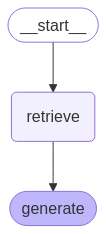

In [24]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
response = graph.invoke({"question": "What is CloudMate?"})

response

{'question': 'What is CloudMate?',
 'context': [Document(id='d79bd8e1-2040-4bb4-a431-8fc4e6e9fd47', metadata={'Header 1': 'About MadeUpCompany', 'Header 2': 'Products and Services', 'Header 3': 'CloudMate – Secure and Scalable Cloud Storage'}, page_content='[About MadeUpCompany/Products and Services/CloudMate – Secure and Scalable Cloud Storage]: \nCloudMate is our flagship cloud storage solution, designed for businesses of all sizes. Features include:\n- ✅ Seamless data migration with automated backups\n- ✅ Military-grade encryption and multi-factor authentication\n- ✅ Role-based access control for enterprise security\n- ✅ AI-powered file organization and search capabilities'),
  Document(id='aa621fa9-5382-489a-b9cb-21297d16dde0', metadata={'Header 1': 'About MadeUpCompany', 'Header 2': 'Pricing', 'Header 3': 'CloudMate Plans'}, page_content='[About MadeUpCompany/Pricing/CloudMate Plans]: \nOur secure and scalable cloud storage service, CloudMate, is available in the following plans:\

# RAG evaluation


We will built our own LLM-as-a-judge evaluation system for our LangGraph RAG system.

We will evaluate for the following:

1. Retrieval Quality (Checks if retrieved documents contain the information needed for answering)

2. Answer Correctness (Ask an LLM whether the generated answer is sufficiently similar to the expected answer)

3. Document Relevance (Evaluates how relevant each retrieved document is to the query)

4. Hallucination Score (Identifies statements in the answer not supported by retrieved documents)

#### Create Question-Answer pairs (Gold standard examples)

In [26]:
sample_queries = [
    "When was MadeUpCompany founded and where is it headquartered?",
    "What security features does CloudMate offer for enterprise customers?",
    "How much does the Professional plan for CloudMate cost and what storage capacity does it include?",
    "What analytics capabilities does DataWiz provide for business intelligence?",
    "What compliance standards does MadeUpCompany adhere to?",
    "What channels are available for technical support at MadeUpCompany?",
    "What is MadeUpCompany's refund policy for the first 30 days?",
    "What upcoming collaboration features is MadeUpCompany planning for CloudMate?",
    "Where are MadeUpCompany's satellite offices located?",
    "What four core values does MadeUpCompany believe in?",
    "What professional backgrounds do MadeUpCompany's experts come from?",
    "What does the Starter plan for DataWiz include and how much does it cost?",
    "How quickly does MadeUpCompany promise to resolve technical issues?",
    "What account management features are available through MadeUpCompany's online portal?",
    "How many users does MadeUpCompany have and what publications have featured them?",
    "What types of custom AI solutions does MadeUpCompany develop?",
    "What encryption standard does MadeUpCompany use and where is it applied?",
    "What are the specifications of the Basic plan for CloudMate?",
    "What is the guaranteed response time for email support at MadeUpCompany?",
    "What capabilities does DataWiz offer for fraud prevention?",
    "How does MadeUpCompany's cancellation policy work after the 30-day period?",
    "What machine learning capabilities will DataWiz introduce in upcoming features?",
    "What pricing plan options are available for MadeUpCompany's Enterprise customers?",
    "What does MadeUpCompany's sustainability value focus on?",
    "How does MadeUpCompany describe its mission?"
]

expected_responses = [
    "MadeUpCompany was founded in 2010 and is headquartered in San Francisco, California.",
    "CloudMate offers military-grade encryption, multi-factor authentication, and role-based access control for enterprise security.",
    "The Professional plan for CloudMate costs $29.99/month and includes 1TB of storage, enhanced security, and priority support.",
    "DataWiz provides predictive analytics for demand forecasting and customer behavior modeling, real-time dashboards with customizable reporting, API integrations with popular business intelligence tools, and automated anomaly detection.",
    "MadeUpCompany adheres to GDPR, HIPAA, and SOC 2 compliance standards for global security and data protection compliance.",
    "MadeUpCompany offers toll-free phone support, live chat assistance, email support, comprehensive FAQ and user guides on their website, and a community forum for peer-to-peer discussions.",
    "MadeUpCompany offers a 30-day money-back guarantee on all plans, allowing customers to request a full refund if they're not satisfied within the first 30 days.",
    "MadeUpCompany is planning to introduce enhanced real-time document editing and team workspaces for seamless collaboration in CloudMate.",
    "MadeUpCompany has satellite offices in New York, London, and Tokyo.",
    "MadeUpCompany believes in innovation, security & privacy, a customer-centric approach, and sustainability.",
    "MadeUpCompany's experts come from various industries including AI research, cybersecurity, and enterprise software development.",
    "The Starter plan for DataWiz costs $49/month and includes basic analytics and limited AI insights.",
    "MadeUpCompany resolves most technical issues within 24 hours, ensuring minimal downtime for businesses.",
    "Through MadeUpCompany's online portal, customers can upgrade or downgrade plans, access billing history and download invoices, manage multiple users and set role-based permissions, and track storage and analytics usage in real time.",
    "MadeUpCompany has over 1 million satisfied users worldwide and has been featured in TechCrunch, Forbes, and Wired as a top innovator.",
    "MadeUpCompany provides tailored machine learning models including NLP-based chatbots and AI-driven recommendation engines to optimize business workflows, automate repetitive tasks, and enhance decision-making.",
    "MadeUpCompany uses AES-256 encryption to protect data both in transit and at rest.",
    "The Basic plan for CloudMate costs $9.99/month and includes 100GB storage and essential security features.",
    "MadeUpCompany guarantees an email support response within 6 hours.",
    "DataWiz provides automated anomaly detection for fraud prevention and operational efficiency.",
    "After 30 days, customers may cancel their subscription at any time, and MadeUpCompany will issue a prorated refund based on the remaining subscription period.",
    "DataWiz will introduce automated trend forecasting powered by deep learning.",
    "MadeUpCompany offers custom pricing for Enterprise plans with unlimited storage, advanced compliance tools, and a dedicated account manager for CloudMate, and full AI customization with dedicated data scientists for DataWiz.",
    "MadeUpCompany's sustainability value focuses on ensuring their infrastructure is energy-efficient and environmentally responsible.",
    "MadeUpCompany's mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation."
]

#### Create a vanilla RAG evaluation system

First, let's create an **LLM Judge**.  We will use [litellm](https://pypi.org/project/litellm/) and [instructor](https://pypi.org/project/instructor/), because we want to make sure we get an exact output from the LLM.

`ìnstructor` allow us to pass in a `response_model` object to the generation method. The response from the llm will be in the same format as the `response_model` object. This is useful for evaluation purposes.

Note also that it makes sense to use a heavier model for evaluation. The ideal is that we iteratively improve our smaller model, but we need a better/bigger model to evaluate the smaller model.

In [37]:

# create a litellm client
litellm.drop_params = True  # watsonx.ai doesn't support `json_mode`
client = instructor.from_litellm(completion, mode=Mode.JSON)

# create a response model - LLM is forced to return an object of this type
class JudgeResponse(BaseModel):
    reasoning: str = Field(description="Short one-sentence reason for score")
    score: Literal[0, .5, 1] = Field(description="Final score")

# define a function to call the judge
def call_judge(prompt : str) -> JudgeResponse:
    response = client.chat.completions.create(
        model="watsonx/meta-llama/llama-3-3-70b-instruct",
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        project_id=WX_PROJECT_ID,
        api_key=WX_API_KEY,
        api_base=WX_API_URL,
        response_model=JudgeResponse,
        # decoding_method="greedy",
        # temperature=0,
    )
    return response

Next, let's write a `RagEvaluator` class that will use our LLM judge to score the output from our RAG system.

In [38]:
class RAGEvaluator:
    """
    A streamlined evaluator for RAG systems focusing on three key dimensions:
    1. Retrieval Quality
    2. Answer Correctness
    3. Hallucination Detection
    """
    def __init__(self, llm_func):
        """Initialize with an LLM."""
        self.llm_func = llm_func
            
    def evaluate_retrieval_quality(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM if retrieved documents contain information needed for the expected answer.
        """
        # Combine all retrieved document contents with clear formatting
        retrieved_text = "\n\n".join([f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(response.get('context', []))])
        
        prompt = f"""You are given a set of documents and a fact. Can the fact be found in the documents? Judge by the information, not the exact wording of the fact.
        
        - Respond with 1 if the fact is present (also if the fact can be pieced together from multiple documents).
        - Respond with 0 if the fact is not present in any of the documents.
        - Responds with 0.5 ff only part of the fact is present.
        
        Retrieved Documents: 
        {retrieved_text}

        Fact:
        {expected_answer}
        
        Can the fact be found in the documents? Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0.
        """
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_retrieval_quality] LLM response: {result}")
        return result
    
    def evaluate_answer_correctness(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM to rate how correct/similar the generated answer is to the expected answer.
        """
        generated_answer = response.get('answer', '')
        
        prompt = f"""You are evaluating a RAG system. You are given a question, an expected answer, and a generated answer. Is the generated answer as correct - or close to as correct - as the expected answer? 
        
        - Respond with 1 if the answer is yes (also if the answer is more detailed than expected)
        - Respond with 0 if the answer is no. 
        - respond with 0.5 if the generated answer is partially correct

        Question:
        {response.get('question', '')}
        
        Expected answer:
        {expected_answer}
        
        Generated answer:
        {generated_answer}
        
        Is the generated answer correct enough? Consider content correctness rather than exact wording. 
        Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0."""
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_answer_correctness] LLM response: {result}")
        return result
    
    def evaluate_hallucination(self, response: dict[str, Any], verbose : bool = False) -> JudgeResponse:
        """
        Ask LLM to evaluate if the answer contains hallucinations.
        """
        generated_answer = response.get('answer', '')
        retrieved_text = "\n\n".join([f"Document {i+1}:\n{doc.page_content}" for i, doc in enumerate(response.get('context', []))])
        
        prompt = f"""You are evaluating a RAG system. Your task is to determine if the generated answer contains hallucinations. Hallucinations are any information that is not directly supported by the retrieved documents. Does the generated answer contain hallucinations? 
        
        - If the answer is no, respond with 0. 
        - If the answer is yes, respond with 1.
        - If the answer is partially hallucinated, respond with 0.5. 
        - If the generated answer states that it does not know, respond with 0.

        Question: 
        {response.get('question', '')}
        
        Retrieved context (this is all the information the AI had access to):
        {retrieved_text}
        
        Generated answer:
        {generated_answer}
        
        Does the generated answer contain hallucinations? Respond as a JudgeResponse object with: 
        - a short reason (max 20 words)
        - a score of 1, 0.5, or 0.
        """
        
        result = self.llm_func(prompt)
        if verbose:
            print(f"[evaluation_hallucination] LLM response: {result}")
        return result
    
    def evaluate(self, response: dict[str, Any], expected_answer: str, verbose : bool = False) -> dict[str, Any]:
        """
        Evaluate a RAG response across all three dimensions.
        """
        # Get scores for each dimension
        retrieval_score = self.evaluate_retrieval_quality(response, expected_answer, verbose=verbose)
        correctness_score = self.evaluate_answer_correctness(response, expected_answer, verbose=verbose)
        hallucination_score = self.evaluate_hallucination(response, verbose=verbose)
        
        return {
            "query": response.get("question", ""),
            "retrieved_context": response.get("context", []),
            "generated_answer": response.get("answer", ""),
            "expected_answer": expected_answer,
            "retrieval_quality": retrieval_score.score,
            "answer_correctness": correctness_score.score, 
            "hallucination_score": hallucination_score.score,  # Lower is better

            # keep the reasoning for manual inspection
            "retrieval_quality_reasoning": retrieval_score.reasoning,
            "answer_correctness_reasoning": correctness_score.reasoning,
            "hallucination_reasoning": hallucination_score.reasoning
        }


def evaluate_rag_system(graph, test_queries, expected_responses, evaluator, verbose=False):
    """
    Evaluate a RAG system on a test set.
    
    Args:
        graph: The LangGraph RAG system with invoke method
        test_queries: List of questions to test
        expected_responses: List of expected answers
        evaluator: The RAG evaluator object
        
    Returns:
        Evaluation results
    """
    results = []
    
    for query, expected in tqdm(zip(test_queries, expected_responses), total=len(test_queries)):

        # Get RAG response
        response = graph.invoke({"question": query})
        
        # Evaluate
        eval_result = evaluator.evaluate(response, expected, verbose=verbose)
        results.append(eval_result)
    
    # Calculate average scores
    avg_metrics = {
        "retrieval_quality": np.mean([r["retrieval_quality"] for r in results]),
        "answer_correctness": np.mean([r["answer_correctness"] for r in results]),
        "hallucination": np.mean([r["hallucination_score"] for r in results])
    }

    return {
        "individual_results": results,
        "scores": avg_metrics,
        "num_queries": len(test_queries)
    }

#### Evaluate the RAG system

In [39]:

results = evaluate_rag_system(
    graph, 
    sample_queries,
    expected_responses,
    evaluator=RAGEvaluator(llm_func=call_judge),
    verbose=True
)

results["scores"]

  0%|          | 0/25 [00:00<?, ?it/s]

[evaluation_retrieval_quality] LLM response: reasoning='Fact found in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Same content, minor wording difference' score=1


  4%|▍         | 1/25 [00:09<03:45,  9.42s/it]

[evaluation_hallucination] LLM response: reasoning='Answer fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Exact match found' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


  8%|▊         | 2/25 [00:18<03:37,  9.45s/it]

[evaluation_hallucination] LLM response: reasoning='Additional benefits not security features' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is identical in content' score=1


 12%|█▏        | 3/25 [00:29<03:42, 10.11s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully described' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


 16%|█▌        | 4/25 [00:37<03:15,  9.32s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 20%|██        | 5/25 [00:46<03:02,  9.13s/it]

[evaluation_hallucination] LLM response: reasoning='Information is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='All support options mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content, extra detail' score=1


 24%|██▍       | 6/25 [00:56<02:58,  9.37s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is partially correct' score=0.5


 28%|██▊       | 7/25 [01:05<02:48,  9.37s/it]

[evaluation_hallucination] LLM response: reasoning='Answer matches retrieved context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in roadmap' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 32%|███▏      | 8/25 [01:15<02:42,  9.57s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Content matches exactly' score=1


 36%|███▌      | 9/25 [01:27<02:43, 10.24s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact matches Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Identical content' score=1


 40%|████      | 10/25 [01:35<02:23,  9.56s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Similar content' score=1


 44%|████▍     | 11/25 [01:44<02:12,  9.47s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact found in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 48%|████▊     | 12/25 [01:53<01:59,  9.19s/it]

[evaluation_hallucination] LLM response: reasoning='Includes unsupported features' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact present in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is mostly correct' score=0.5


 52%|█████▏    | 13/25 [02:01<01:47,  8.95s/it]

[evaluation_hallucination] LLM response: reasoning='Directly supported by Document 1' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully described' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 56%|█████▌    | 14/25 [02:12<01:43,  9.37s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by context' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully present' score=1
[evaluation_answer_correctness] LLM response: reasoning='Answer is accurate' score=1


 60%|██████    | 15/25 [02:20<01:31,  9.12s/it]

[evaluation_hallucination] LLM response: reasoning='Answer fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact fully described' score=1
[evaluation_answer_correctness] LLM response: reasoning='Very similar content' score=1


 64%|██████▍   | 16/25 [02:29<01:21,  9.05s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is supported by documents' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Explicitly mentioned in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed, equally correct' score=1


 68%|██████▊   | 17/25 [02:38<01:12,  9.08s/it]

[evaluation_hallucination] LLM response: reasoning='Answer fully supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact found in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 72%|███████▏  | 18/25 [02:48<01:04,  9.17s/it]

[evaluation_hallucination] LLM response: reasoning='Includes features not in Basic plan doc' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Email support guarantee found' score=1
[evaluation_answer_correctness] LLM response: reasoning='Matches expected answer' score=1


 76%|███████▌  | 19/25 [02:56<00:53,  8.92s/it]

[evaluation_hallucination] LLM response: reasoning='Directly supported by Document 1' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Exact fact mentioned' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 80%|████████  | 20/25 [03:05<00:44,  8.95s/it]

[evaluation_hallucination] LLM response: reasoning='Minor expansion on anomaly detection' score=0.5
[evaluation_retrieval_quality] LLM response: reasoning='Fact is present' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 84%|████████▍ | 21/25 [03:14<00:35,  8.95s/it]

[evaluation_hallucination] LLM response: reasoning='Answer is directly supported' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in roadmap' score=1
[evaluation_answer_correctness] LLM response: reasoning='More detailed than expected' score=1


 88%|████████▊ | 22/25 [03:24<00:28,  9.41s/it]

[evaluation_hallucination] LLM response: reasoning='Zero-knowledge encryption misinterpreted' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Partially mentioned' score=0.5
[evaluation_answer_correctness] LLM response: reasoning='Partially correct details' score=0.5


 92%|█████████▏| 23/25 [03:33<00:18,  9.10s/it]

[evaluation_hallucination] LLM response: reasoning='Mentions unspecified customizable plans' score=1
[evaluation_retrieval_quality] LLM response: reasoning='Fact mentioned in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Exact match' score=1


 96%|█████████▌| 24/25 [03:41<00:08,  8.77s/it]

[evaluation_hallucination] LLM response: reasoning='Directly supported by Document 1' score=0
[evaluation_retrieval_quality] LLM response: reasoning='Fact stated in Document 1' score=1
[evaluation_answer_correctness] LLM response: reasoning='Generated answer is more detailed' score=1


100%|██████████| 25/25 [03:50<00:00,  9.21s/it]

[evaluation_hallucination] LLM response: reasoning='Partial match, added details' score=0.5


{'retrieval_quality': 0.98, 'answer_correctness': 0.94, 'hallucination': 0.22}

#### Plot the evaluation results

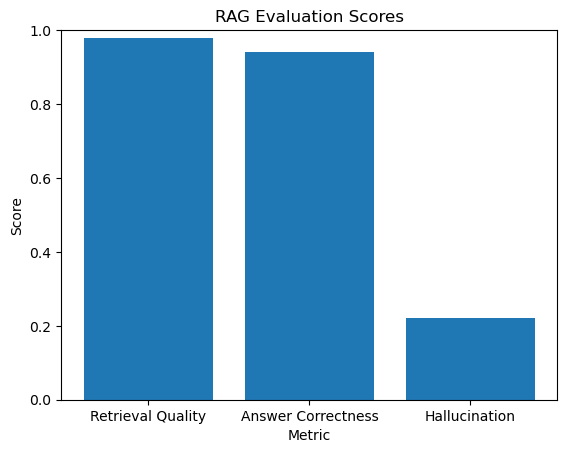

In [40]:
def plot_scores(scores):
    """
    Plot the evaluation scores.
    """
    labels = ["Retrieval Quality", "Answer Correctness", "Hallucination"]
    scores = [scores["retrieval_quality"], scores["answer_correctness"], scores["hallucination"]]
    
    _, ax = plt.subplots()
    ax.bar(labels, scores)
    ax.set_xlabel('Metric')
    # set y range to 0-1
    ax.set_ylim(0, 1)
    ax.set_ylabel('Score')
    ax.set_title('RAG Evaluation Scores')
    plt.show()

plot_scores(results["scores"])

#### Inspection of the evaluation results

In [41]:
results["individual_results"][:5]

[{'query': 'When was MadeUpCompany founded and where is it headquartered?',
  'retrieved_context': [Document(id='ed9530ce-cbf7-4384-84d1-90d1770027b4', metadata={'Header 1': 'About MadeUpCompany'}, page_content='[About MadeUpCompany]: \nMadeUpCompany is a pioneering technology firm founded in 2010, specializing in cloud computing, data analytics, and machine learning. Headquartered in San Francisco, California, we have a global presence with satellite offices in New York, London, and Tokyo. Our mission is to empower businesses and individuals with cutting-edge technology that enhances efficiency, scalability, and innovation.  \nWith a diverse team of experts from various industries—including AI research, cybersecurity, and enterprise software development—we push the boundaries of what’s possible. Our commitment to continuous improvement, security, and customer success has earned us recognition as a leader in the tech space.'),
   Document(id='4e2d70b4-ed8f-4d45-a1f7-bf163e187d02', meta

## What can we optimize?

| Component | Importance | Parameters and Design Choices |
|:-----------|:------------|:-------------------------------|
| <div style="width:60px">**1. Document preprocessing**</div> | <div style="width:150px">Affects quality of information encoded into vector embeddings. Clean, well-structured text leads to better embeddings and more accurate retrieval.</div> | <div style="width:350px">• Text cleaning (HTML tags, special characters, whitespace)<br>• Language detection and filtering<br>• Deduplication of similar content<br>• Sentence normalization (casing, punctuation)<br>• Named entity recognition<br>• Content filtering (boilerplate, headers/footers)<br>• Metadata extraction and preservation<br>• Document dating/versioning<br>• OCR quality improvement<br>• Table and structured data extraction</div> |
| **2. Document chunking strategy** | Determines how documents are split into retrievable pieces, directly impacting what information is retrieved together and context boundaries. | • Chunk size (token/character count)<br>• Overlap between chunks<br>• Semantic vs. fixed-length chunking<br>• Hierarchy-aware chunking<br>• Chunk methods (sentence, paragraph, section)<br>• Metadata preservation within chunks<br>• Document structure preservation<br>• Special handling for lists, tables, code blocks<br>• Entity-based chunking<br>• Recursive chunking with different granularities |
| **3. Embedding model** | Converts text into vector representations that capture semantic meaning, determining how effectively similar content can be retrieved. | • Model size and performance trade-offs<br>• Domain-specific vs. general-purpose embeddings<br>• Multilingual vs. monolingual models<br>• Fine-tuning on domain-specific data<br>• Dimensionality of embeddings<br>• Asymmetric embeddings (query vs. document)<br>• Hybrid embedding approaches<br>• Sentence vs. paragraph vs. document-level embeddings<br>• Token context window limitations<br>• Cost and latency considerations |
| **4. Vector index** | Affects retrieval speed, accuracy, and scalability of the system. | • Index type (HNSW, IVF, FLAT, ANNOY)<br>• Quantization parameters<br>• Number of lists/clusters in IVF<br>• Number of neighbors in HNSW<br>• Index refresh strategy<br>• Sharding and distribution approach<br>• Metadata filtering capabilities<br>• Disk vs. memory trade-offs<br>• Indexing parameters (construction time vs. quality)<br>• Multi-vector indexing |
| **5. Retrieval parameters** | Control how candidates are fetched and ranked, balancing between precision, recall, and performance. | • Top-k retrieved documents<br>• Distance/similarity metrics<br>• Diversity parameters (MMR, clustering)<br>• Hybrid retrieval (keyword + semantic)<br>• Re-ranking strategies<br>• Query expansion and reformulation<br>• Filtering by metadata<br>• Thresholding (minimum similarity score)<br>• Multi-query approaches<br>• Context-aware retrieval |
| **6. RAG prompt template** | Determines how retrieved information is incorporated and used by the LLM, affecting output quality and factuality. | • Few-shot examples in prompts<br>• Structured vs. unstructured context inclusion<br>• Citation and source attribution mechanics<br>• Query-focused context summarization<br>• Multi-step reasoning frameworks<br>• Context compression techniques<br>• Handling of conflicting information<br>• Template adaptation based on document types<br>• Metadata integration into prompts<br>• System instructions for grounding |
| **7. LLM model** | Processes retrieved information and generates the final response, with capabilities directly affecting output quality. | • Model size and capability<br>• Specialized vs. general-purpose models<br>• Fine-tuning on domain-specific data<br>• Instruction tuning for RAG-specific tasks<br>• Context window size<br>• Temperature and sampling parameters<br>• Token budget allocation<br>• Response format control<br>• Chain-of-thought prompting compatibility<br>• Tool use capabilities |
| **8. Evaluation metrics** | Provide quantitative and qualitative assessment of system performance, guiding improvement efforts. | • Faithfulness/factuality metrics<br>• Relevance of retrieved documents<br>• Answer correctness (against ground truth)<br>• Diversity of retrieved information<br>• Response completeness metrics<br>• Latency and throughput measurements<br>• User satisfaction metrics<br>• Task-specific metrics<br>• Retrieval precision, recall, and F1 scores<br>• A/B testing frameworks |